### FIN 3080 homework 2 qiujunwen 122090436
DATA loading

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data1 = pd.read_excel('TRD_Mnth.xlsx')
data2 = pd.read_excel('FI_T5(Merge Query).xlsx')
data3 = pd.read_excel('STK_MKT_STKBTAL.xlsx')
data4 = pd.read_excel('TRD_Mont.xlsx')

data1 = data1.drop(data1.index[:2])
data2 = data2.drop(data2.index[:2])
data3 = data3.drop(data3.index[:2])
data4 = data4.drop(data4.index[:2])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


DATA preprocessing

In [56]:
data1.columns = ['Code', 'Trading month', 'Monthly closing price', 'Monthly return']
data2.columns = ['Code', 'Short name', 'Ending date', 'Statement type', 'Return on equity', 'Net assets per share']
data3.columns = ['Code', 'Trading date', 'Return volatility']
data4.columns = ['Market type', 'Trading month', 'Monthly market return']

# fill the NaN value at corresponding recent value


data1.fillna(method='ffill', inplace=True)
data2.fillna(method='ffill', inplace=True)
data3.fillna(method='ffill', inplace=True)
data4.fillna(method='ffill', inplace=True)
# change the data type of the date columns to datetime

data1['Trading month'] = pd.to_datetime(data1['Trading month'])
data2['Ending date'] = pd.to_datetime(data2['Ending date'])
data3['Trading date'] = pd.to_datetime(data3['Trading date'])
data4['Trading month'] = pd.to_datetime(data4['Trading month'])

# select the data after 2009-11 and exclude the parent financial statement
data1 = data1[data1['Trading month'] > '2009-11']
musk = (data2['Ending date'] > '2009-11') & (data2['Statement type'] == 'A')
data2 = data2[musk]
data3 = data3[data3['Trading date'] == '2010-12-31']
# change the data type of the columns to the correct type
data1 = data1.astype({'Code': 'str', 'Monthly closing price': 'float', 'Monthly return': 'float'})
data2 = data2.astype({'Code': 'str', 'Return on equity': 'float', 'Net assets per share': 'float'})
data3 = data3.astype({'Code': 'str', 'Return volatility': 'float'})
data4 = data4.astype({'Market type': 'str', 'Monthly market return': 'float'})

data4 = data4[data4['Market type'] == '1']


# reset the index
data1 = data1.reset_index(drop=True)
data2 = data2.reset_index(drop=True)
data3 = data3.reset_index(drop=True)
data4 = data4.reset_index(drop=True)

# catch a basic glimpse of dataset

data viewing

In [57]:
data4

,Market type,Trading month,Monthly market return
0,1,2009-12-01,0.033036
1,1,2010-01-01,-0.090872
2,1,2010-02-01,0.025093
3,1,2010-03-01,0.025648
4,1,2010-04-01,-0.077143
...,...,...,...
167,1,2023-11-01,0.000178
168,1,2023-12-01,-0.017079
169,1,2024-01-01,-0.039058
170,1,2024-02-01,0.074265


In [58]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553039 entries, 0 to 553038
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Code                   553039 non-null  object        
 1   Trading month          553039 non-null  datetime64[ns]
 2   Monthly closing price  553039 non-null  float64       
 3   Monthly return         553039 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 16.9+ MB


In [59]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208985 entries, 0 to 208984
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Code                  208985 non-null  object        
 1   Short name            208985 non-null  object        
 2   Ending date           208985 non-null  datetime64[ns]
 3   Statement type        208985 non-null  object        
 4   Return on equity      208985 non-null  float64       
 5   Net assets per share  208985 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 9.6+ MB


In [60]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Code               1692 non-null   object        
 1   Trading date       1692 non-null   datetime64[ns]
 2   Return volatility  1692 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 39.8+ KB


In [61]:
data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Market type            172 non-null    object        
 1   Trading month          172 non-null    datetime64[ns]
 2   Monthly market return  172 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.2+ KB


In [62]:
# define an adjusting function to create lagged varibles
def add_lagged(trading_time):
    year = trading_time.year
    month = trading_time.month
    day = trading_time.day
    if month in [1, 2, 3]:
        return f"{year-1}-12-31"
    if month in [4, 5, 6]:
        return f"{year}-03-31"
    if month in [7, 8, 9]:
        return f"{year}-06-30"
    if month in [10, 11, 12]:
        return f"{year}-09-30"
    
data1['Ending date'] = data1['Trading month'].apply(add_lagged)
data1['Ending date'] = pd.to_datetime(data1['Ending date'])
data1 = data1[data1['Trading month'] >= '2009-12-31']
# merge the necessary data into a single dataframe
data = pd.merge(left=data1, right=data2, on=['Code', 'Ending date'], how='inner')
data.head()

,Code,Trading month,Monthly closing price,Monthly return,Ending date,Short name,Statement type,Return on equity,Net assets per share
0,000001,2010-01-01,21.70,-0.109561,2009-12-31,SFZA,A,0.272887,6.591545
1,000001,2010-02-01,22.45,0.034562,2009-12-31,SFZA,A,0.272887,6.591545
2,000001,2010-03-01,23.20,0.033408,2009-12-31,SFZA,A,0.272887,6.591545
3,000001,2010-04-01,20.56,-0.113793,2010-03-31,SFZA,A,0.280066,7.119722
4,000001,2010-05-01,17.51,-0.148346,2010-03-31,SFZA,A,0.280066,7.119722


In [63]:
# derive monthly P/B ratio from Jan. 2010 to Dec. 2023
data['Monthly PB'] = data['Monthly closing price'] / data['Net assets per share']

# Calculate the 5th and 95th percentiles of P/B ratio in the overall dataset 
pb_5th_percentile = data['Monthly PB'].quantile(0.05)
pb_95th_percentile = data['Monthly PB'].quantile(0.95)

# exclude the records with P/B ratio lower than the 5th percentile or higher than the 95th percentile
filtered_data = data[(data['Monthly PB'] >= pb_5th_percentile) & (data['Monthly PB'] <= pb_95th_percentile)]
# Filter the data based on the monthly PB values in the filtered_data
data = data[data['Monthly PB'].isin(filtered_data['Monthly PB'])].reset_index(drop=True)
data

,Code,Trading month,Monthly closing price,Monthly return,Ending date,Short name,Statement type,Return on equity,Net assets per share,Monthly PB
0,000001,2010-01-01,21.70,-0.109561,2009-12-31,SFZA,A,0.272887,6.591545,3.292096
1,000001,2010-02-01,22.45,0.034562,2009-12-31,SFZA,A,0.272887,6.591545,3.405878
2,000001,2010-03-01,23.20,0.033408,2009-12-31,SFZA,A,0.272887,6.591545,3.519660
3,000001,2010-04-01,20.56,-0.113793,2010-03-31,SFZA,A,0.280066,7.119722,2.887753
4,000001,2010-05-01,17.51,-0.148346,2010-03-31,SFZA,A,0.280066,7.119722,2.459366
...,...,...,...,...,...,...,...,...,...,...
486682,873703,2024-01-01,30.33,-0.211798,2023-12-31,GXHN,A,0.173437,12.459286,2.434329
486683,873703,2024-02-01,28.06,-0.074843,2023-12-31,GXHN,A,0.173437,12.459286,2.252135
486684,873726,2023-10-01,21.80,-0.074843,2023-09-30,ZZDJ,A,0.593777,4.578955,4.760912
486685,873726,2023-11-01,29.15,0.337156,2023-09-30,ZZDJ,A,0.593777,4.578955,6.366081


Problem 1: Regress P/B ratio at the end of 2010 with variable ROE and stock volatility:

In [64]:
data

,Code,Trading month,Monthly closing price,Monthly return,Ending date,Short name,Statement type,Return on equity,Net assets per share,Monthly PB
0,000001,2010-01-01,21.70,-0.109561,2009-12-31,SFZA,A,0.272887,6.591545,3.292096
1,000001,2010-02-01,22.45,0.034562,2009-12-31,SFZA,A,0.272887,6.591545,3.405878
2,000001,2010-03-01,23.20,0.033408,2009-12-31,SFZA,A,0.272887,6.591545,3.519660
3,000001,2010-04-01,20.56,-0.113793,2010-03-31,SFZA,A,0.280066,7.119722,2.887753
4,000001,2010-05-01,17.51,-0.148346,2010-03-31,SFZA,A,0.280066,7.119722,2.459366
...,...,...,...,...,...,...,...,...,...,...
486682,873703,2024-01-01,30.33,-0.211798,2023-12-31,GXHN,A,0.173437,12.459286,2.434329
486683,873703,2024-02-01,28.06,-0.074843,2023-12-31,GXHN,A,0.173437,12.459286,2.252135
486684,873726,2023-10-01,21.80,-0.074843,2023-09-30,ZZDJ,A,0.593777,4.578955,4.760912
486685,873726,2023-11-01,29.15,0.337156,2023-09-30,ZZDJ,A,0.593777,4.578955,6.366081


In [65]:
data3

,Code,Trading date,Return volatility
0,000001,2010-12-31,0.375077
1,000002,2010-12-31,0.360978
2,000004,2010-12-31,0.382118
3,000005,2010-12-31,0.409691
4,000006,2010-12-31,0.502408
...,...,...,...
1687,900952,2010-12-31,0.236365
1688,900953,2010-12-31,0.326092
1689,900955,2010-12-31,0.307338
1690,900956,2010-12-31,0.385223


In [66]:
# Select the required columns for regression
regression_data = (data[(data['Ending date'] == '2010-09-30') & (data['Trading month'] == '2010-12-01')]).reset_index(drop = True)
regression_data = pd.merge(left=data3, right=regression_data, on='Code', how='inner')

# regression_data['Code', 'Monthly PB', 'Return on equity', 'Return volatility']
regression_data = regression_data[['Code', 'Monthly PB', 'Return on equity', 'Return volatility']]

regression_data

,Code,Monthly PB,Return on equity,Return volatility
0,000001,1.711926,0.239194,0.375077
1,000002,1.831914,0.143634,0.360978
2,000004,7.999336,0.229803,0.382118
3,000005,4.969425,-0.090036,0.409691
4,000006,2.436701,0.141314,0.502408
...,...,...,...,...
1384,601958,5.873981,0.049726,0.517640
1385,601988,1.371196,0.183965,0.201127
1386,601991,2.026694,0.093324,0.285140
1387,601998,1.693021,0.183411,0.357737


In [67]:
# start the regression analysis
import statsmodels.api as sm
X = regression_data[['Return on equity', 'Return volatility']]
X = sm.add_constant(X)  # Add a constant term
y = regression_data['Monthly PB']

model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Monthly PB   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     107.5
Date:                Sat, 06 Apr 2024   Prob (F-statistic):           3.82e-44
Time:                        21:28:00   Log-Likelihood:                -2885.9
No. Observations:                1389   AIC:                             5778.
Df Residuals:                    1386   BIC:                             5794.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0966      0.28

Problem 2: Average return graph capturing monthly P/B ratio factors over a decade

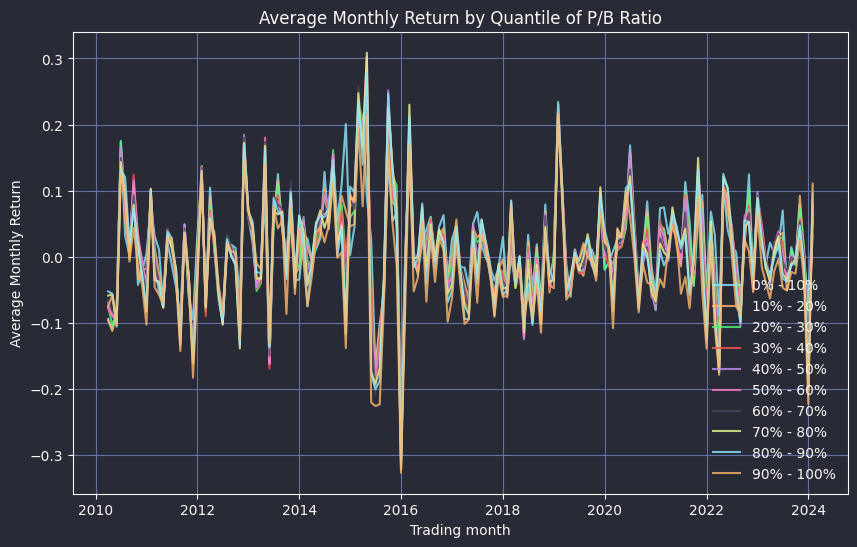

,Trading month,Quantile,Monthly return
0,2010-04-01,0,-0.094210
1,2010-04-01,1,-0.096315
2,2010-04-01,2,-0.075110
3,2010-04-01,3,-0.079145
4,2010-04-01,4,-0.069283
...,...,...,...
1665,2024-02-01,5,0.054665
1666,2024-02-01,6,0.108188
1667,2024-02-01,7,0.076978
1668,2024-02-01,8,0.095491


In [80]:
# first create lagged PB for each stock, implying the last month PB ratio
data = data.sort_values(by=['Code', 'Trading month']).reset_index(drop=True)
data['Lagged PB'] = data.groupby('Code')['Monthly PB'].shift(1)
data.dropna(subset='Lagged PB', inplace=True) 

#reorder the data for furthter separation based on PB ratio in each month
# data = data.sort_values(by=['Trading month', 'Monthly PB']).reset_index(drop=True)

# Calculate quantiles separately through time
data['Quantile'] = data.groupby('Trading month')['Lagged PB'].transform(lambda x: pd.qcut(x, q=10, labels=False))

# Group the data by Trading month and Quantile, and calculate the average monthly return
# (suppose we equally weight the stocks in each quantile)
average_return = data.groupby(['Trading month', 'Quantile'])['Monthly return'].mean().reset_index()

# Plot the average monthly return for each quantile
import matplotx
with plt.style.context(matplotx.styles.dracula):
    plt.figure(figsize=(10, 6))
    for quantile in range(10):
        quantile_data = average_return[average_return['Quantile'] == quantile]
        label = f'{quantile * 10}% - {(quantile + 1) * 10}%'
        plt.plot(quantile_data['Trading month'], quantile_data['Monthly return'], label=label, alpha=0.8)
    plt.xlabel('Trading month')
    plt.ylabel('Average Monthly Return')
    plt.title('Average Monthly Return by Quantile of P/B Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

average_return

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


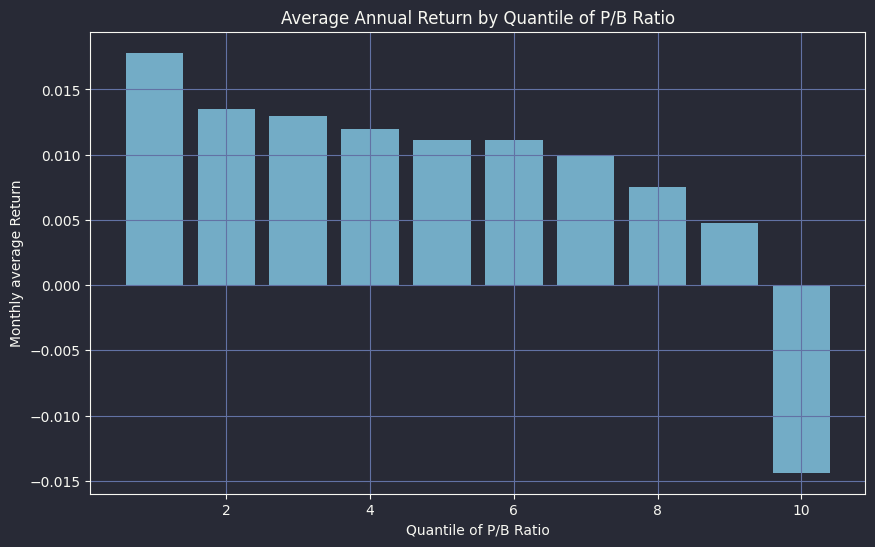

In [69]:
# count the average return of each quantile from the panal data 
quantile_average_return = average_return.groupby('Quantile')['Monthly return'].mean()
import matplotx
with plt.style.context(matplotx.styles.dracula):
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, 11), quantile_average_return, alpha=0.8, color='skyblue')
    plt.xlabel('Quantile of P/B Ratio')
    plt.ylabel('Monthly average Return')
    plt.title('Average Annual Return by Quantile of P/B Ratio')
    plt.legend()
    plt.grid()
    plt.show()
    

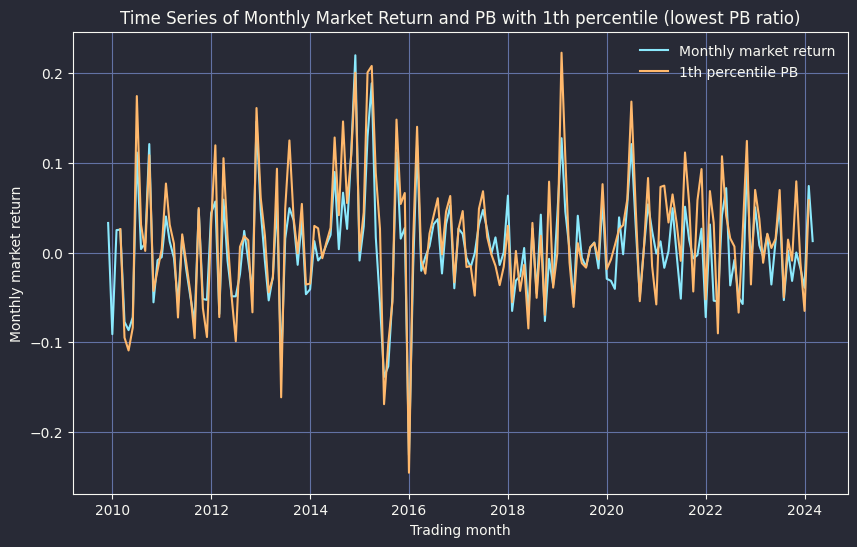

In [104]:
import matplotlib.pyplot as plt

# Extract the necessary columns from the data4 DataFrame
trading_month = data4['Trading month']
monthly_market_return = data4['Monthly market return']

# Filter the data based on the condition, here we select the 1th and 10th percentile PB
filtered_data1 = average_return[average_return['Quantile'] == 0]
filtered_data2 = average_return[average_return['Quantile'] == 9]

# Plot the time series graph for the 10th percentile PB
with plt.style.context(matplotx.styles.dracula):
    plt.figure(figsize=(10, 6))
    plt.plot(trading_month, monthly_market_return, label='Monthly market return')
    plt.plot(filtered_data['Trading month'], filtered_data['Monthly return'], label='1th percentile PB')
    plt.xlabel('Trading month')
    plt.ylabel('Monthly market return')
    plt.title('Time Series of Monthly Market Return and PB with 1th percentile (lowest PB ratio)')
    plt.legend()
    plt.grid(True)
    plt.show()



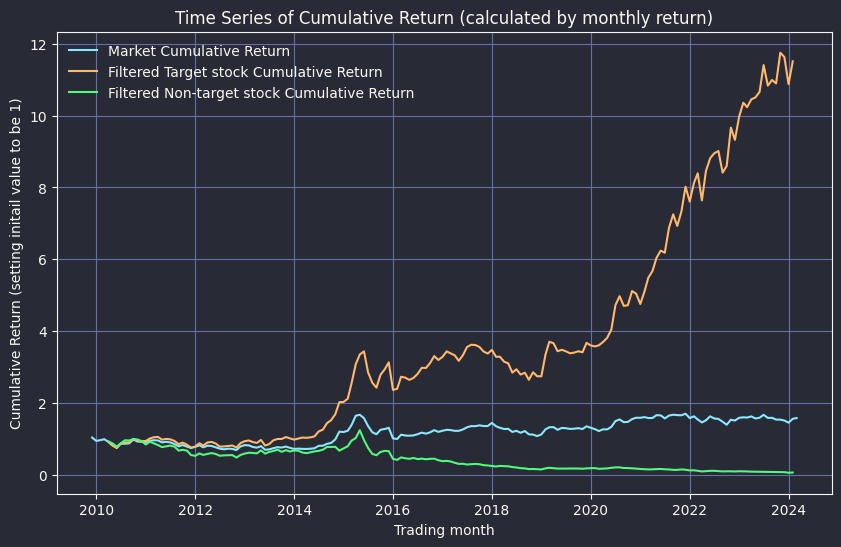

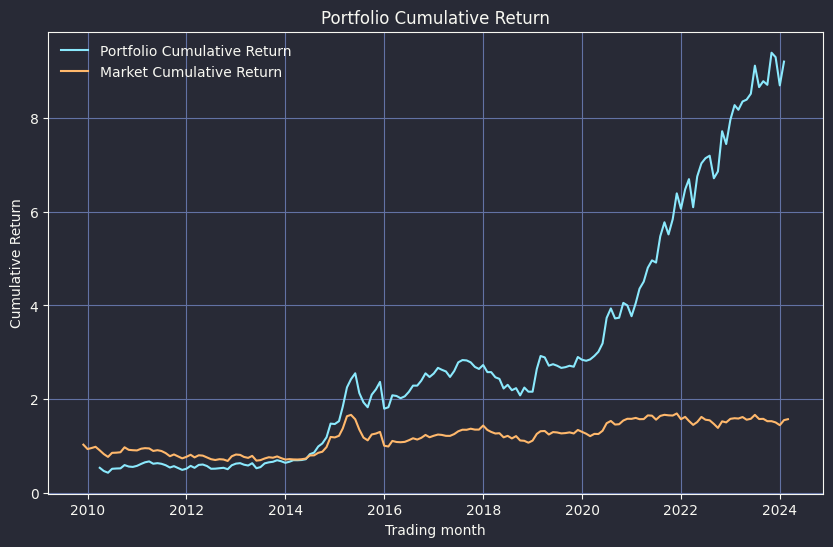

In [138]:
# 计算市场收益的累积收益
market_cumulative_return = (1 + monthly_market_return).cumprod()

# 计算筛选数据的累积收益
filtered_data_cumulative_return1 = (1 + filtered_data1['Monthly return']).cumprod().reset_index(drop=True)
filtered_data_cumulative_return2 = (1 + filtered_data2['Monthly return']).cumprod().reset_index(drop=True)


# 绘制累积收益图
with plt.style.context(matplotx.styles.dracula):
    plt.figure(figsize=(10, 6))
    plt.plot(trading_month, market_cumulative_return, label='Market Cumulative Return')
    plt.plot(filtered_data1['Trading month'], filtered_data_cumulative_return1, label='Filtered Target stock Cumulative Return')
    plt.plot(filtered_data2['Trading month'], filtered_data_cumulative_return2, label='Filtered Non-target stock Cumulative Return')
    plt.xlabel('Trading month')
    plt.ylabel('Cumulative Return (setting initail value to be 1)')
    plt.title('Time Series of Cumulative Return (calculated by monthly return)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate the portfolio cumulative returns
# Calculate the portfolio cumulative return
portfolio_cumulative_return = 0.8 * filtered_data_cumulative_return1 + (-0.2) * filtered_data_cumulative_return2

# Plot the cumulative returns
with plt.style.context(matplotx.styles.dracula):
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data1['Trading month'], portfolio_cumulative_return, label='Portfolio Cumulative Return')
    plt.plot(trading_month, market_cumulative_return, label='Market Cumulative Return')
    plt.xlabel('Trading month')
    plt.ylabel('Cumulative Return')
    plt.title('Portfolio Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()


In [94]:
import numpy as np

# Calculate the excess returns of the strategy and the market, suppose the risk-free rate is 2%
strategy_excess_returns = filtered_data['Monthly return'] - 0.02
market_excess_returns = monthly_market_return - 0.02

# Calculate the standard deviation of the excess returns
strategy_std = np.std(strategy_excess_returns)
market_std = np.std(market_excess_returns)

# Calculate the mean of the excess returns
strategy_mean = np.mean(strategy_excess_returns)
market_mean = np.mean(market_excess_returns)

# Calculate the Sharpe ratio
strategy_sharpe_ratio = (strategy_mean - 0.02) / strategy_std
market_sharpe_ratio = (market_mean - 0.02) / market_std

# Calculate the annualized return
strategy_annual_return = np.mean(filtered_data['Monthly return']) * 12
market_annual_return = np.mean(monthly_market_return) * 12

print('The annualized return of the PB strategy is:', strategy_annual_return)
print('The annualized return of the market is:', market_annual_return)


The annualized return of the PB strategy is: 0.20722337513787215
The annualized return of the market is: 0.05148523255813953


In [137]:
extra_return = filtered_data_cumulative_return1.iloc[-1] - market_cumulative_return.iloc[-1]
# calculate the annualized extra return for the strategy compared to the market
print('The annualized strategy extra return compared to the market is: ', extra_return**(1/13)-1)
# Calculate the maximum drawdown
returns = filtered_data_cumulative_return1.pct_change()
cum_returns = (1 + returns).cumprod()
peak = cum_returns.cummax()
drawdown = (cum_returns - peak) / peak
max_drawdown = drawdown.min()

# Print the maximum drawdown
print('The maximum drawdown is:', max_drawdown)


The annualized strategy extra return compared to the market is:  0.19317774568599755
The maximum drawdown is: -0.3128752926750837
